# 1. Multi-Agent system

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datascienceworld-kan/vinagent/blob/main/docs/docs/tutorials/get_started/multi_agent.ipynb)


May be, you are familiar with single agent design of Vinagent, which uses an LLM as brain to control tools and workflow of an application. However, as you develop many operational systems in many real enterprises, the operational procedure might be very complex, which requires a transformation from single-agent into multi-agent system over time. For example, you may have to tackle with the following challanges:

- Single agent increases it's workload, therefore, it need too many tools in use, which in return making a poor decision about which tool to call next.
- Context growing huge preventing agent from capturing the main important keypoints.
- Multiple specialization areas requires a complex system of multi-agent to deal with (e.g. planner, researcher, math expert, etc.)

Therefore, to tackle these, it is necessary to break your application into multiple agents, each agent has their own skills to be integrated into a multi-agent system. Comparing with single-agent, multi-agent system has a primary benefits are:

- Modularity: Separate agents simplify development and debugging.
- Specialization: Expert agents improve domain performance.
- Control: Explicit communication improves transparency and governance.

![](https://raw.githubusercontent.com/datascienceworld-kan/vinagent/refs/heads/main/docs/docs/get_started/images/multi_agent_architectures.png)

Source: Langchain blog.

There are several ways to develop a multi-agent system:

- Network: All agents can talk directly with each other, and each one decides whom to call next.
- Supervisor: Agents only talk to a central supervisor, which decides the next agent to invoke.
- Supervisor (tool-calling): A variant where agents act like tools, and the supervisor LLM decides which tool-agent to use and what arguments to provide.
- Hierarchical: Supervisors can themselves have supervisors, enabling layered control structures.
- Custom workflow: Agents only connect with specific subsets, with some flows being fixed and others allowing limited decision-making.

In this tutorial, let's study how to develop a multi-agent system using Vinagent library.


Multi-agent feature is supported from vinagent version `0.0.6`. Therefore, you should install upgradation version first:

In [ ]:
!pip install vinagent=0.0.6

Initialize LLM model.

In [ ]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv('.env'))

llm = ChatOpenAI(
    model = "o4-mini"
)

You should define `OPENAI_API_KEY` inside `.env` file.

# 2. Multi-agent with Vinangent

Vinagent designs an advanced multi-agent solution with key strengths:
- Specialized Agents: Each [single agent](https://datascienceworld-kan.github.io/vinagent/#component-overview) is fully equipped with its own LLM, tools, memory, skills, and authentication layer.
- Shared Conversation: Agents collaborate seamlessly in the same conversation, enabling them to capture and utilize each other’s context.
- Human-in-the-Loop: Users can directly participate and interact within the agent workflow.
- Customizable Order: A Crew class allows flexible control over the sequence of agents in a conversation.

# 2.1. AgentNode

Each agent member in a multi-agent system is setup from [Vinagent's Agent class](https://datascienceworld-kan.github.io/vinagent/get_started/basic_agent/#setup-an-agent). However, to empower these agents to join in the same conversation, we specifically design a class `AgentNode` as a Proxy Class, which will be implemented for each agent. While initializing a new Agent class, you need to do following:

- Create a specific class inherites the AgentNode.
- Re-define `exec` method inside this class, which triggers invoking function (is one of `invoke, ainvoke, and stream`) inside. The behavior of triggers invoking function is similar as [Vinagent's Agent triggering](https://datascienceworld-kan.github.io/vinagent/get_started/async_invoke/)
- The conversation is recorded inside a state, which is accessible with every members.

```python
class ExampleAgent(AgentNode):   
    def exec(self, state: State) -> dict:
        messages = state["messages"]
        output = self.invoke(messages)
        return {"messages": {"role": "AgentPositive", "content": output}}
```

To showcase the efficiency of Vinagent’s multi-agent system, we use the real-world case of customer service support on an e-commerce platform. The workflow follows this pipeline:

**Input → Supervisor Agent → [Negative | Positive | Neutral Agent] → Staff Agent → Output**

- Supervisor Agent: Analyzes customer comments on purchased products and classifies them as negative, positive, or neutral.

- Routing: Depending on the classification, the comment is forwarded to the corresponding agent (Negative, Positive, or Neutral).

- Negative Agent: Responds with an apology, collects user details (email, phone), and forwards them to the Staff Agent.

- Staff Agent: Applies customer care policies and sends a follow-up email to the customer.

- Positive & Neutral Agents: Since these cases are non-critical, they process the feedback accordingly without escalation.


![](/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/docs/docs/get_started/images/customer_service_support.png)

Let's initialize each specific agent class by implementing `AgentNode`, each one should re-define `exec` method to deal with the return answer.

In [ ]:
from typing import Annotated, TypedDict
from vinagent.logger.logger import logging_message
from vinagent.multi_agent import AgentNode
from vinagent.multi_agent import CrewAgent

# Define a reducer for message history
def append_messages(existing: list, update: str) -> list:
    return existing + [update]

# Define the state schema
class State(TypedDict):
    messages: Annotated[list[str], append_messages]
    sentiment: str

# Define node classes
class Supervisor(AgentNode):
    @logging_message
    def exec(self, state: State) -> dict:
        message = state["messages"][-1]["content"]
        output = self.invoke(message)
        sentiment = 'neutral'
        if 'negative' in output.content.lower():
            sentiment = 'negative'
        elif 'positive' in output.content.lower():
            sentiment = 'positive'
        return {"messages": {"role": "Supervisor", "content": output}, "sentiment": sentiment}

    def branching(self, state: State) -> str:
        return state["sentiment"]

class AgentPositive(AgentNode):
    @logging_message
    def exec(self, state: State) -> dict:
        messages = state["messages"]
        output = self.invoke(messages)
        return {"messages": {"role": "AgentPositive", "content": output}}

class AgentNegative(AgentNode):
    @logging_message
    def exec(self, state: State) -> dict:
        messages = state["messages"]
        output = self.invoke(messages)
        return {"messages": {"role": "AgentNegative", "content": output}}

class AgentNeutral(AgentNode):
    @logging_message
    def exec(self, state: State) -> dict:
        messages = state["messages"]
        output = self.invoke(messages)
        return {"messages": {"role": "AgentNeutral", "content": output}}

class AgentStaff(AgentNode):
    @logging_message
    def exec(self, state: State) -> dict:
        messages = state["messages"]
        print(f'agent staff input messages: {messages}')
        output = self.invoke(messages)
        return {"messages": {"role": "AgentStaff", "content": output}}

Initializing the member agents join in the crew replying on their specific Agent class.

In [ ]:
supervisor = Supervisor(
    name="supervisor",
    description="A Supervisor agent who manage the task and assign it to your member agents",
    instruction="You only answer in one of three options: 'negative', 'positive', 'neutral'",
    llm=llm,
    skills=[
        "Classify user's query sentiment"
        "Assign task to member agents",
    ],
    tools=[
        "vinagent/tools/hello.py"
        # Let's provide an absolute path on local, you can download tool at: 
        # https://github.com/datascienceworld-kan/vinagent/blob/main/vinagent/tools/hello.py
    ],
    memory_path="/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/supervisor/memory.json",
    tools_path = "/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/supervisor/tool.json"
)

agent_positive = AgentPositive(
    name="agent_positive",
    description="agent_positive agent process positive feedback",
    instruction="Customer is very happy let's thank you to them and ask them for rating",
    llm=llm,
    skills = [
        "Give thank's you to user",
    ],
    memory_path="/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/positive/memory.json",
    tools_path = "/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/positive/tool.json"
)

agent_negative = AgentNegative(
    name="agent_negative",
    description="agent_negative agent process negative feedback",
    instruction="Customer is unhappy with our service, let's show your sympathy with them, ask his information including email and number phone to forward to staff",
    llm=llm,
    skills = [
        "Give apology to user",
        "Asking for to make detailed complaints"
    ],
    memory_path="/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/negative/memory.json",
    tools_path = "/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/negative/tool.json"
)

agent_neutral = AgentNeutral(
    name="agent_neutral",
    description="agent_neutral agent process neutral feedback",
    instruction="You should respond by a decent utterance",
    llm=llm,
    skills = [
        "Understand customer intent and answer to them"
    ],
    memory_path="/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/neutral/memory.json",
    tools_path = "/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/neutral/tool.json"
)


agent_staff = AgentStaff(
    name="agent_staff",
    description="agent_staff to process customer complaints",
    instruction="Customer is unhappy with our service, let's analyze his complaints and write an sorry email to them with detailed compensation",
    llm=llm,
    skills = [
        "Give an apology email to user",
        "Confirm customer number phone again"
    ],
    tools=[
        "/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/vinagent/tools/crm_system/apology_incorrect_delivery_email.py"
        # Let's provide an absolute path on local. You can download tool at: 
        # https://github.com/datascienceworld-kan/vinagent/blob/main/vinagent/tools/crm_system/apology_incorrect_delivery_email.py
    ],
    memory_path="/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/staff/memory.json",
    tools_path = "/Users/phamdinhkhanh/Documents/Courses/Manus/vinagent/templates/mutli_agent/staff/tool.json"
)

Organizing each agent with its own dedicated folder for memory and tools creates a secure, isolated architecture that prevents interference and conflicts between agents. This separation ensures safety during updates since you can modify one agent's memory and tools without affecting others, while also enabling specialized customization for each agent's specific role. The folder-based approach optimizes performance by allowing agents to load only what they need and operate in parallel without stepping on each other's data. Most importantly, this structure provides robust security and safety guarantees, ensuring that each agent's sensitive data and specialized tools remain protected and accessible only when appropriate.

![](https://raw.githubusercontent.com/datascienceworld-kan/vinagent/refs/heads/main/docs/docs/get_started/images/template_multi_agent.png)

_Hierarchiral structure seperates out each agent memory and tool according._

## 2.2. Human-in-the-loop

Humans can join the multi-agent system to provide feedback and messages. You should define the main information that the user inputs into the multi-agent system inside the `exec` method of the `UserFeedback` class. The following is a `user_feedback` instance that will be integrated into the crew agent.

In [ ]:
from vinagent.multi_agent import UserFeedback

class Feedback(UserFeedback):
    def exec(self, state: State) -> dict: # Must have state in argument
        email = input("Please provide your email:")
        phone = input("Please provide your phone:")
        output = f'Email: {email}; Phone: {phone}'
        return {"messages": {"role": "user", "content": output}}

user_feedback = Feedback(
    name="user_feedback",
    role="user"
)


Note: Organizing each agent with its own dedicated folder for memory and tools creates a secure, isolated architecture that prevents interference and conflicts between agents. This separation ensures safety during updates since you can modify one agent's memory and tools without affecting others, while also enabling specialized customization for each agent's specific role. The folder-based approach optimizes performance by allowing agents to load only what they need and operate in parallel without stepping on each other's data. Most importantly, this structure provides robust security and safety guarantees, ensuring that each agent's sensitive data and specialized tools remain protected and accessible only when appropriate.

![](../images/template_multi_agent.png)

_Hierarchiral structure seperates out each agent memory and tool according._


## 2.3. Crew of Agent

Crew class is group of agents who join in this conversatio


In [ ]:
from vinagent.graph.operator import FlowStateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# Optional config schema
class ConfigSchema(TypedDict):
    user_id: str

# Initialize Crew
crew = CrewAgent(
    llm = llm,
    checkpoint = MemorySaver(),
    graph = FlowStateGraph(State, config_schema=ConfigSchema),
    flow = [
        supervisor >> {
            "positive": agent_positive,
            "neutral": agent_neutral,
            "negative": agent_negative,
        },
        agent_positive >> END,
        agent_neutral >> END,
        agent_negative >> user_feedback,
        user_feedback >> agent_staff,
        agent_staff >> END
    ]
)

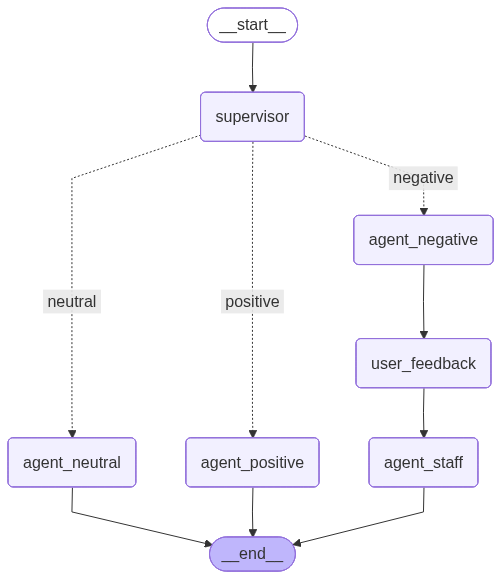

In [6]:
crew.compiled_graph

## 3.1. Invoke

To kick-off multi-agent system, you only need to pass query inside `invoke()` method.

In [ ]:
query="I'm not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."
result = crew.invoke(query=query, user_id="Kan", thread_id=123)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.register.tool:Registered hello_from_vinagent:
{'tool_name': 'hello_from_vinagent', 'arguments': {}, 'return': 'Any', 'docstring': 'A greet of Vinagent to everyone', 'dependencies': [], 'module_path': 'vinagent.tools.hello', 'tool_type': 'module', 'tool_call_id': 'tool_e9dafe82-4ac4-4767-be33-2cf2f1ef0a8'}
INFO:vinagent.register.tool:Completed registration for module vinagent.tools.hello
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.register.tool:Registered sale_content:
{'tool_name': 'sale_content', 'arguments': {'email': "<class 'str'>", 'phone_number': "<class 'str'>"}, 'return': 'Any', 'docstring': 'Sent an apology email to customer\n    Args:\n        email (str): Customer email to sent apology.\n        phone_number (str): Number phone of customer to contact\n    Return:\n        An apology email content', 'dependencies

{'input': {'messages': {'role': 'user', 'content': "I'm not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."}}, 'config': {'configurable': {'user_id': 'Kan'}, 'thread_id': 123}}
history:  [SystemMessage(content="A Supervisor agent who manage the task and assign it to your member agents\nYour skills:\n- Classify user's query sentimentAssign task to member agents\nInstruction:\nYou only answer in one of three options: 'negative', 'positive', 'neutral'", additional_kwargs={}, response_metadata={}), HumanMessage(content='You are given a task, a list of available tools, and the memory about user to have precise information.\n- Task: I\'m not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out.\n- Tools list: {"hello_from_vinagent": {"tool_name": "hello_from_vinagent", "arguments": {}, "return": "Any", "docstring": "A greet of Vinagent to everyone", "dependencies": [], "module_path": "vinagent.tools.

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 1 iterations.
INFO:vinagent.logger.logger:

============ Supervisor Response ============
{'messages': {'role': 'Supervisor', 'content': AIMessage(content='negative', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 404, 'total_tokens': 551, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--1db6bd1f-8290-46c1-aa84-08ff9b582661-0', usage_metadata={'input_tokens': 404, 'output_tokens': 147, 'total_tokens': 551, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0

history:  [SystemMessage(content="agent_negative agent process negative feedback\nYour skills:\n- Give apology to user- Asking for to make detailed complaints\nInstruction:\nCustomer is unhappy with our service, let's show your sympathy with them, ask his information including email and number phone to forward to staff", additional_kwargs={}, response_metadata={}), HumanMessage(content='You are given a task, a list of available tools, and the memory about user to have precise information.\n- Task: [{\'role\': \'user\', \'content\': "I\'m not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."}, {\'role\': \'Supervisor\', \'content\': AIMessage(content=\'negative\', additional_kwargs={\'refusal\': None}, response_metadata={\'token_usage\': {\'completion_tokens\': 147, \'prompt_tokens\': 404, \'total_tokens\': 551, \'completion_tokens_details\': {\'accepted_prediction_tokens\': 0, \'audio_tokens\': 0, \'reasoning_tokens\': 128, \'rejected_pre

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 1 iterations.
INFO:vinagent.logger.logger:

============ AgentNegative Response ============
{'messages': {'role': 'AgentNegative', 'content': AIMessage(content='Hello unknown_user, I’m very sorry to hear about this. It sounds like you ordered 5 items but only received 4, and the paper wrapper arrived torn. I understand how frustrating that must be. To get this resolved as quickly as possible, could you please provide:\n\n• Your order number  \n• Your email address  \n• A phone number where we can reach you  \n\nOnce we have that information, I’ll forward everything to our support team right away. Thank you for your patience, and again, my apologies for the trouble.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 446, 'prompt_tokens': 554, 'total_tokens': 1000, 'completion_tokens_detai

agent staff input messages: [{'role': 'user', 'content': "I'm not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."}, {'role': 'Supervisor', 'content': AIMessage(content='negative', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 404, 'total_tokens': 551, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--1db6bd1f-8290-46c1-aa84-08ff9b582661-0', usage_metadata={'input_tokens': 404, 'output_tokens': 147, 'total_tokens': 551, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}})}, {'role': 'AgentNegative', 'content': AIMessage(content='Hello unknown_

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'sale_content', 'tool_type': 'module', 'arguments': {'email': 'vippro_customer@gmail.com', 'phone_number': '849468686868'}, 'module_path': 'vinagent.tools.apology_incorrect_delivery_email'}
INFO:vinagent.register.tool:Completed executing module tool sale_content({'email': 'vippro_customer@gmail.com', 'phone_number': '849468686868'})
INFO:vinagent.agent.agent:Tool calling iteration 2/10


history:  [SystemMessage(content="agent_staff to process customer complaints\nYour skills:\n- Give an apology email to user- Confirm customer number phone again\nInstruction:\nCustomer is unhappy with our service, let's analyze his complaints and write an sorry email to them with detailed compensation", additional_kwargs={}, response_metadata={}), HumanMessage(content='You are given a task, a list of available tools, and the memory about user to have precise information.\n- Task: [{\'role\': \'user\', \'content\': "I\'m not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."}, {\'role\': \'Supervisor\', \'content\': AIMessage(content=\'negative\', additional_kwargs={\'refusal\': None}, response_metadata={\'token_usage\': {\'completion_tokens\': 147, \'prompt_tokens\': 404, \'total_tokens\': 551, \'completion_tokens_details\': {\'accepted_prediction_tokens\': 0, \'audio_tokens\': 0, \'reasoning_tokens\': 128, \'rejected_prediction_tokens\': 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'sale_content', 'tool_type': 'module', 'arguments': {'email': 'vippro_customer@gmail.com', 'phone_number': '849468686868'}, 'module_path': 'vinagent.tools.apology_incorrect_delivery_email'}
INFO:vinagent.register.tool:Completed executing module tool sale_content({'email': 'vippro_customer@gmail.com', 'phone_number': '849468686868'})
INFO:vinagent.agent.agent:Tool calling iteration 3/10


history:  [SystemMessage(content="agent_staff to process customer complaints\nYour skills:\n- Give an apology email to user- Confirm customer number phone again\nInstruction:\nCustomer is unhappy with our service, let's analyze his complaints and write an sorry email to them with detailed compensation", additional_kwargs={}, response_metadata={}), HumanMessage(content='You are given a task, a list of available tools, and the memory about user to have precise information.\n- Task: [{\'role\': \'user\', \'content\': "I\'m not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."}, {\'role\': \'Supervisor\', \'content\': AIMessage(content=\'negative\', additional_kwargs={\'refusal\': None}, response_metadata={\'token_usage\': {\'completion_tokens\': 147, \'prompt_tokens\': 404, \'total_tokens\': 551, \'completion_tokens_details\': {\'accepted_prediction_tokens\': 0, \'audio_tokens\': 0, \'reasoning_tokens\': 128, \'rejected_prediction_tokens\': 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 3 iterations.
INFO:vinagent.logger.logger:

============ AgentStaff Response ============
{'messages': {'role': 'AgentStaff', 'content': AIMessage(content='Subject: Apology and Resolution for Your Recent Order  \nTo: vippro_customer@gmail.com  \nPhone: 849468686868  \n\nDear Valued Customer,  \n\nI’m very sorry to hear that you received only four of the five items you ordered and that the paper wrapper arrived torn. That’s not the experience we strive to deliver, and I understand how frustrating this must be.  \n\nTo make things right, here’s what we’d like to do:  \n1. Immediate Replacement  \n   – We will ship the missing item at no additional cost to you.  \n   – Your replacement will be sent via expedited shipping, on us, so you receive it as quickly as possible.  \n2. Refund Option  \n   – If you’d rather receive a refund for 

Note: In there, each user will have their own identification by `user_id`. Each conversation should be kicked-off inside a specific `thread_id` to support parallel executions while there many requests to crew in the production environment. The default value of `thread_id` is `123`.

In [3]:
for mess in result['messages']:
    content=mess['content'].content if hasattr(mess['content'], "content") else mess['content']
    print(f"======== {mess['role']} Response ========\n{content}\n\n")

======== user Response ========
I'm not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out.


======== Supervisor Response ========
negative


======== AgentNegative Response ========
Hello unknown_user, I’m very sorry to hear about this. It sounds like you ordered 5 items but only received 4, and the paper wrapper arrived torn. I understand how frustrating that must be. To get this resolved as quickly as possible, could you please provide:

• Your order number  
• Your email address  
• A phone number where we can reach you  

Once we have that information, I’ll forward everything to our support team right away. Thank you for your patience, and again, my apologies for the trouble.


======== user Response ========
Email: vippro_customer@gmail.com; Phone: 849468686868


======== AgentStaff Response ========
Subject: Apology and Resolution for Your Recent Order  
To: vippro_customer@gmail.com  
Phone: 849468686868  

Dear Valued Customer,  



## 3.2. Asynchronously Invoke

In many case, we need to optimize speed by asynchronously invoking. This allow asynchronous execution while handling I/O tasks like I/O data, request to external server.

In [ ]:
query="I'm not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."
result = await crew.ainvoke(query=query, user_id="Kan", thread_id=123)

INFO:vinagent.multi_agent.crew:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:I'am chatting with unknown_user
INFO:vinagent.agent.agent:Tool calling iteration 1/10


history:  [SystemMessage(content="A Supervisor agent who manage the task and assign it to your member agents\nYour skills:\n- Classify user's query sentimentAssign task to member agents\nInstruction:\nYou only answer in one of three options: 'negative', 'positive', 'neutral'", additional_kwargs={}, response_metadata={}), HumanMessage(content='You are given a task, a list of available tools, and the memory about user to have precise information.\n- Task: I\'m not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out.\n- Tools list: {"hello_from_vinagent": {"tool_name": "hello_from_vinagent", "arguments": {}, "return": "Any", "docstring": "A greet of Vinagent to everyone", "dependencies": [], "module_path": "vinagent.tools.hello", "tool_type": "module", "tool_call_id": "tool_e9dafe82-4ac4-4767-be33-2cf2f1ef0a8"}}\n\n- User: unknown_user\n------------------------\nInstructions:\n- Let\'s answer in a natural, clear, and detailed way without providi

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 1 iterations.
INFO:vinagent.logger.logger:

============ Supervisor Response ============
{'messages': {'role': 'Supervisor', 'content': AIMessage(content='negative', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 806, 'total_tokens': 953, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--d03eb4b8-48ad-4349-ad04-8ded54dcea36-0', usage_metadata={'input_tokens': 806, 'output_tokens': 147, 'total_tokens': 953, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0

history:  [SystemMessage(content="agent_negative agent process negative feedback\nYour skills:\n- Give apology to user- Asking for to make detailed complaints\nInstruction:\nCustomer is unhappy with our service, let's show your sympathy with them, ask his information including email and number phone to forward to staff", additional_kwargs={}, response_metadata={}), HumanMessage(content='You are given a task, a list of available tools, and the memory about user to have precise information.\n- Task: [{\'role\': \'user\', \'content\': "I\'m not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."}, {\'role\': \'Supervisor\', \'content\': AIMessage(content=\'negative\', additional_kwargs={\'refusal\': None}, response_metadata={\'token_usage\': {\'completion_tokens\': 147, \'prompt_tokens\': 404, \'total_tokens\': 551, \'completion_tokens_details\': {\'accepted_prediction_tokens\': 0, \'audio_tokens\': 0, \'reasoning_tokens\': 128, \'rejected_pre

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 1 iterations.
INFO:vinagent.logger.logger:

============ AgentNegative Response ============
{'messages': {'role': 'AgentNegative', 'content': AIMessage(content='Hello unknown_user, I’m truly sorry you’ve had this experience. I see you’ve already shared your email and phone—thank you for that. To help us track down your order and make things right as quickly as possible, could you please provide:\n\n• Your order number  \n• A photo of the torn paper wrapper (if it’s convenient)  \n\nOnce I have those details, I’ll escalate this to our support team immediately to arrange the missing item shipment or process a refund—whichever you prefer. Again, my sincere apologies for the inconvenience, and thank you for your patience.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 328, 'prompt_tokens

agent staff input messages: [{'role': 'user', 'content': "I'm not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."}, {'role': 'Supervisor', 'content': AIMessage(content='negative', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 404, 'total_tokens': 551, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--1db6bd1f-8290-46c1-aa84-08ff9b582661-0', usage_metadata={'input_tokens': 404, 'output_tokens': 147, 'total_tokens': 551, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 128}})}, {'role': 'AgentNegative', 'content': AIMessage(content='Hello unknown_

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'sale_content', 'tool_type': 'module', 'arguments': {'email': 'phamdinhkkhanh.tkt53.neu@gmail.com', 'phone_number': '849468686868'}, 'module_path': 'vinagent.tools.apology_incorrect_delivery_email'}
INFO:vinagent.register.tool:Completed executing module tool sale_content({'email': 'phamdinhkkhanh.tkt53.neu@gmail.com', 'phone_number': '849468686868'})
INFO:vinagent.agent.agent:Tool calling iteration 2/10


history:  [AIMessage(content='{\n  "tool_name": "sale_content",\n  "tool_type": "module",\n  "arguments": {\n    "email": "vippro_customer@gmail.com",\n    "phone_number": "849468686868"\n  },\n  "module_path": "vinagent.tools.apology_incorrect_delivery_email"\n}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 530, 'prompt_tokens': 2610, 'total_tokens': 3140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1024}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--b26c9e7b-189a-40c4-8185-4c48ba78c489-0', tool_calls=[{'name': 'sale_content', 'args': {'email': 'vippro_customer@gmail.com', 'phone_number': '849468686868'}, 'type': 'tool_call', 'id': 'tool_d2a81583-9f25-4173-8169-169aa8a492b'}], usage_metadata={'input_tokens': 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 2 iterations.
INFO:vinagent.logger.logger:

============ AgentStaff Response ============
{'messages': {'role': 'AgentStaff', 'content': AIMessage(content='Subject: Apology and Resolution for Your Recent Order  \nTo: phamdinhkkhanh.tkt53.neu@gmail.com  \nPhone: 849468686868  \n\nDear Valued Customer,\n\nI’m very sorry to hear that your order arrived with only four of the five items you requested, and that the paper wrapper was torn. This falls short of the high standard we aim to provide, and I understand how disappointing and inconvenient this must be.\n\nTo make things right, here’s what we’d like to offer:\n\n1. Immediate Replacement  \n   – We will ship the missing item at no additional cost.  \n   – Your replacement will be sent via expedited shipping, free of charge, so you receive it as soon as possible.\n\n2. Refund Option 

## 3.3. Streaming
You can stream each output of each agent inside crew system by using `stream()` method.

In [ ]:
for message in crew.stream(query=query, user_id="Kan", thread_id=123):
    print(message)

INFO:vinagent.multi_agent.crew:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:I'am chatting with unknown_user
INFO:vinagent.agent.agent:Tool calling iteration 1/10


history:  [SystemMessage(content="A Supervisor agent who manage the task and assign it to your member agents\nYour skills:\n- Classify user's query sentimentAssign task to member agents\nInstruction:\nYou only answer in one of three options: 'negative', 'positive', 'neutral'", additional_kwargs={}, response_metadata={}), HumanMessage(content='You are given a task, a list of available tools, and the memory about user to have precise information.\n- Task: I\'m not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out.\n- Tools list: {"hello_from_vinagent": {"tool_name": "hello_from_vinagent", "arguments": {}, "return": "Any", "docstring": "A greet of Vinagent to everyone", "dependencies": [], "module_path": "vinagent.tools.hello", "tool_type": "module", "tool_call_id": "tool_e9dafe82-4ac4-4767-be33-2cf2f1ef0a8"}}\n\n- User: unknown_user\n------------------------\nInstructions:\n- Let\'s answer in a natural, clear, and detailed way without providi

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 1 iterations.
INFO:vinagent.logger.logger:

============ Supervisor Response ============
{'messages': {'role': 'Supervisor', 'content': AIMessage(content='negative', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 211, 'prompt_tokens': 1208, 'total_tokens': 1419, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--46d536f0-cb97-4ea6-b491-27af2a597674-0', usage_metadata={'input_tokens': 1208, 'output_tokens': 211, 'total_tokens': 1419, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio

{'messages': {'role': 'Supervisor', 'content': AIMessage(content='negative', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 211, 'prompt_tokens': 1208, 'total_tokens': 1419, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--46d536f0-cb97-4ea6-b491-27af2a597674-0', usage_metadata={'input_tokens': 1208, 'output_tokens': 211, 'total_tokens': 1419, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}})}, 'sentiment': 'negative'}
history:  [SystemMessage(content="agent_negative agent process negative feedback\nYour skills:\n- Give apology to user- Asking for to make detailed complaints\nInstruction:\nCustomer is unhappy 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 1 iterations.
INFO:vinagent.logger.logger:

============ AgentNegative Response ============
{'messages': {'role': 'AgentNegative', 'content': AIMessage(content='Hello unknown_user, I’m truly sorry you’re still experiencing issues with your order. I understand how frustrating it is to receive only four of the five items and to find the paper wrapper torn. To get this sorted out right away, could you please let me know:\n\n• Your order number  \n• Whether you’d prefer a replacement of the missing item or a refund  \n• (Optional) A photo of the torn paper wrapper\n\nOnce I have those details, I’ll escalate everything to our support team immediately and make sure you’re taken care of. Again, my sincere apologies for the inconvenience, and thank you for your patience.', additional_kwargs={'refusal': None}, response_metadata={'token_usa

{'messages': {'role': 'AgentNegative', 'content': AIMessage(content='Hello unknown_user, I’m truly sorry you’re still experiencing issues with your order. I understand how frustrating it is to receive only four of the five items and to find the paper wrapper torn. To get this sorted out right away, could you please let me know:\n\n• Your order number  \n• Whether you’d prefer a replacement of the missing item or a refund  \n• (Optional) A photo of the torn paper wrapper\n\nOnce I have those details, I’ll escalate everything to our support team immediately and make sure you’re taken care of. Again, my sincere apologies for the inconvenience, and thank you for your patience.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 336, 'prompt_tokens': 5387, 'total_tokens': 5723, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio

INFO:vinagent.agent.agent:No authentication card provided, skipping authentication
INFO:vinagent.agent.agent:I'am chatting with unknown_user
INFO:vinagent.agent.agent:Tool calling iteration 1/10


{'messages': {'role': 'user', 'content': 'Email: vippro_customer@gmail.com; Phone: 849468686868 '}}
agent staff input messages: [{'role': 'user', 'content': "I'm not happy about this product. I ordered 5, but you delivered 4 items. The paper wrapper is torn out."}, {'role': 'Supervisor', 'content': AIMessage(content='negative', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 147, 'prompt_tokens': 404, 'total_tokens': 551, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--1db6bd1f-8290-46c1-aa84-08ff9b582661-0', usage_metadata={'input_tokens': 404, 'output_tokens': 147, 'total_tokens': 551, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'aud

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:Executing tool call: {'tool_name': 'sale_content', 'tool_type': 'module', 'arguments': {'email': 'vippro_customer@gmail.com', 'phone_number': '849468686868'}, 'module_path': 'vinagent.tools.apology_incorrect_delivery_email'}
INFO:vinagent.register.tool:Completed executing module tool sale_content({'email': 'vippro_customer@gmail.com', 'phone_number': '849468686868'})
INFO:vinagent.agent.agent:Tool calling iteration 2/10


history:  [AIMessage(content='{\n  "tool_name": "sale_content",\n  "tool_type": "module",\n  "arguments": {\n    "email": "phamdinhkkhanh.tkt53.neu@gmail.com",\n    "phone_number": "849468686868"\n  },\n  "module_path": "vinagent.tools.apology_incorrect_delivery_email"\n}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 346, 'prompt_tokens': 5759, 'total_tokens': 6105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--b47e233f-e064-43fa-9ce5-3fd4217fb57d-0', tool_calls=[{'name': 'sale_content', 'args': {'email': 'phamdinhkkhanh.tkt53.neu@gmail.com', 'phone_number': '849468686868'}, 'type': 'tool_call', 'id': 'tool_d2a81583-9f25-4173-8169-169aa8a492b'}], usage_metadata={'

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:vinagent.agent.agent:No more tool calls needed. Completed in 2 iterations.
INFO:vinagent.logger.logger:

============ AgentStaff Response ============
{'messages': {'role': 'AgentStaff', 'content': AIMessage(content='Subject: Apology and Resolution for Your Recent Order  \nTo: vippro_customer@gmail.com  \nPhone: 849468686868  \n\nDear Valued Customer,\n\nI’m very sorry to hear that you received only four of the five items you ordered and that the paper wrapper arrived torn. This is far below the level of service we aim to deliver, and I completely understand how frustrating and inconvenient this must be.\n\nTo make things right, we would like to offer you the following options:\n\n1. Immediate Replacement  \n   – We will ship the missing item at no additional cost to you.  \n   – Your replacement will be sent via expedited shipping, free of charge, so you receive it as soon as possible.\n\n2

{'messages': {'role': 'AgentStaff', 'content': AIMessage(content='Subject: Apology and Resolution for Your Recent Order  \nTo: vippro_customer@gmail.com  \nPhone: 849468686868  \n\nDear Valued Customer,\n\nI’m very sorry to hear that you received only four of the five items you ordered and that the paper wrapper arrived torn. This is far below the level of service we aim to deliver, and I completely understand how frustrating and inconvenient this must be.\n\nTo make things right, we would like to offer you the following options:\n\n1. Immediate Replacement  \n   – We will ship the missing item at no additional cost to you.  \n   – Your replacement will be sent via expedited shipping, free of charge, so you receive it as soon as possible.\n\n2. Refund Option  \n   – If you’d prefer a refund for the missing item instead of a replacement, please let us know. We will process it immediately and send you confirmation once it’s complete.\n\n3. Goodwill Discount  \n   – As an apology for the 